# SYDE 556/750 --- Assignment 3
**Student ID: 20814292**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [395]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

In [396]:
class Constants:
    DX = 0.05
    TAU_REF = 2.0e-3
    TAU_RC = 20.0e-3
    SIGMA = 0.1 * 200
    FILTER_TAU = 5.0e-3
    FILTER_T = 0.1 # [s]
    DT = 1.0e-3 # [s]
    T = 1.0 # [s]
    SPIKE_VOLTAGE = 5.0 # [V], arbitrarily chosen
    RESTING_VOLTAGE = 0.0 # [V]
    THRESHOLD_VOLTAGE = 1.0 # [V]
    SPIKE_VALUE = 1.0
    REFACTORY_COUNT = int(TAU_REF / DT)

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

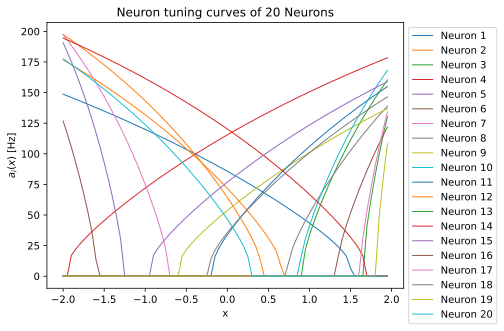

In [397]:
n = 20 # number of neurons
radius = 2.0 # x-intercept max absolute value
x = np.arange(-radius, radius, Constants.DX)

maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
x_intercepts = np.random.uniform(-radius, radius, size=(n, 1))
encoders = np.random.choice([1, -1], size=(n, 1))

def G(_J: np.ndarray):
    _J[_J > 1] = 1.0 / (Constants.TAU_REF - Constants.TAU_RC * np.log(1 - (1/_J[_J > 1])))
    _J[_J <= 1] = 0
    return _J

alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / Constants.TAU_RC) * (Constants.TAU_REF - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)
j_bias = (radius - (x_intercepts / (1.0 - np.exp((1.0 / Constants.TAU_RC) * (Constants.TAU_REF - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)

A = G(alphas * encoders @ x.reshape(1, len(x)) + j_bias)

for i in range(n):
    plt.plot(x, A[i, :], label=f'Neuron {i+1}', linewidth='1')

plt.title(f"Neuron tuning curves of {n} Neurons")
plt.xlabel('x')
plt.ylabel('$a_{i}(x)$ [Hz]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

(20, 80)


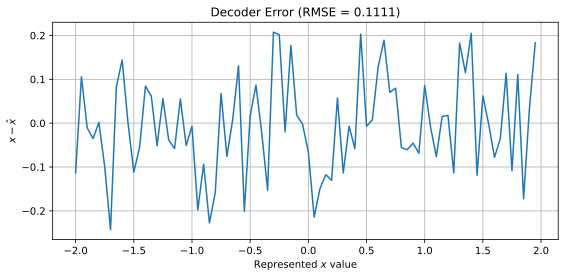

In [398]:
def rmse(_actual, _predicted):
    return np.sqrt(np.mean((_actual - _predicted) ** 2))

noise = np.random.normal(0, Constants.SIGMA, size=A.shape)
noisy_A = A + noise
noisy_D = np.array(np.linalg.lstsq(A @ A.T + len(x) * np.square(Constants.SIGMA) * np.eye(n), A @ x, rcond=None)[0])
x_hat = noisy_A.T @ noisy_D
noisy_A_noisy_D_RMSE = rmse(x, x_hat)
print(A.shape)
# Plot the difference x - x_hat
plt.figure(figsize=(8, 4))
plt.plot(x, x - x_hat)
plt.title('Decoder Error' + f' (RMSE = {noisy_A_noisy_D_RMSE:.4f})')
plt.xlabel('Represented $x$ value')
plt.ylabel('$x - \hat{x}$')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

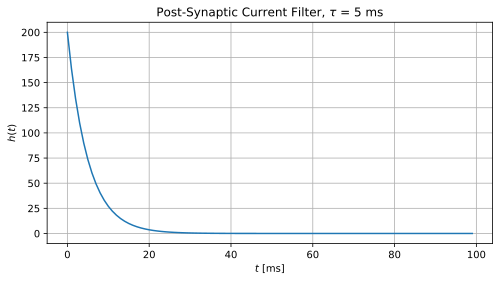

In [399]:
filter_t = np.arange(0, Constants.FILTER_T, Constants.DT)

def h_n0(_time_vector):
    return np.where(_time_vector >= 0, np.exp(-_time_vector / Constants.FILTER_TAU) / Constants.FILTER_TAU, 0)
h_n0_t = h_n0(filter_t)

plt.figure(figsize=(8, 4))
plt.plot(filter_t * 1000, h_n0_t)
plt.title(r'Post-Synaptic Current Filter, $\tau$ = ' + f'{Constants.FILTER_TAU * 1000:.0f} ms')
plt.xlabel('$t$ [ms]')
plt.ylabel('$h(t)$')
plt.grid()
plt.show()

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

In [400]:
def generate_band_limited_white_noise(_rms, _limit, _seed:int = 0):
    np.random.seed(_seed)

    _N = int(Constants.T / Constants.DT) # total # of samples
    _t = np.arange(0, Constants.T, Constants.DT)

    _w = 2 * np.pi * np.fft.fftfreq(_N, d=Constants.DT) # units = [rad/s]
    
    # Create random values for the positive frequency components
    _X_w_positive = np.random.randn(_N//2 + 1) + 1j * np.random.randn(_N//2 + 1)
    
    # Mirror values from positive to negative frequencies
    _X_w = np.zeros(_N, dtype=complex)
    _X_w[:_N//2 + 1] = _X_w_positive
    _X_w[_N//2 + 1:] = np.conjugate(_X_w_positive[1:-1][::-1])

    # Apply frequency limit by setting components above limit to zero
    _X_w[np.abs(_w) > (2 * np.pi * _limit)] = 0
    
    _x_t = np.fft.ifft(_X_w).real

    # Scale the signal to match the desired rms
    _rms_correction_factor = _rms / np.sqrt(np.mean(_x_t**2))
    _x_t *= _rms_correction_factor
    _X_w = _rms_correction_factor * _X_w

    return _t, _x_t, np.fft.fftshift(_w), np.fft.fftshift(_X_w)

In [401]:
def simulate_LIF_neuron(_x_t, _e: list, _alpha: list, _j_bias: list):
    def J(_x, _e, _alpha, _j_bias):
        return _alpha * _e * _x + _j_bias # _x is a scalar
    
    _V_x_arr = []
    assert len(_e) == len(_alpha)
    assert len(_alpha) == len(_j_bias)

    for i in range(len(_e)):
        _V_x = []
        refractory_counter = 0
        for curr_x in _x_t:
            if len(_V_x) == 0:
                _V_x.append(Constants.RESTING_VOLTAGE)
                continue
            elif refractory_counter > 0:
                _V_x.append(0)
                refractory_counter -= 1
                continue
            elif _V_x[-1] < Constants.THRESHOLD_VOLTAGE:
                _dv = Constants.DT * (1 / Constants.TAU_RC) * (J(curr_x, _e[i], _alpha[i], _j_bias[i]) - _V_x[-1]) 
                if _dv + _V_x[-1] < 0: _dv = -_V_x[-1]
            elif _V_x[-1] >= Constants.THRESHOLD_VOLTAGE and _V_x[-1] < Constants.SPIKE_VOLTAGE:
                _dv = Constants.SPIKE_VOLTAGE - _V_x[-1]
            else:
                _dv = -Constants.SPIKE_VOLTAGE
                refractory_counter = Constants.REFACTORY_COUNT
            _V_x.append(_V_x[-1] + _dv)
        _V_x_arr.append(_V_x)
    return np.array(_V_x_arr), np.where(np.array(_V_x_arr) == Constants.SPIKE_VOLTAGE, Constants.SPIKE_VALUE, 0.0)

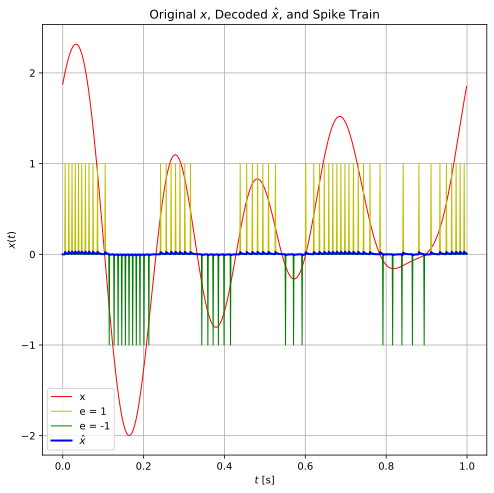

In [402]:
rms = 1
limit = 5
A_at_zero = A[:, (A.shape[1] - 1) // 2]
selected_neuron_index = np.where((A_at_zero >= 20) & (A_at_zero <= 50))[0][0]
selected_alpha = alphas[selected_neuron_index][0]
selected_j_bias = j_bias[selected_neuron_index][0]

t, x_t, _, _ = generate_band_limited_white_noise(rms, limit)

A_spiking_voltage, A_spiking_spike = simulate_LIF_neuron(x_t, [1, -1], [selected_alpha]*2, [selected_j_bias]*2)
noisy_D = np.array(np.linalg.lstsq(A_spiking_spike @ A_spiking_spike.T + len(x_t) * np.square(Constants.SIGMA) * np.eye(A_spiking_spike.shape[0]), A_spiking_spike @ x_t, rcond=None)[0])

x_hat_t = A_spiking_spike.T @ noisy_D
x_hat_t = np.convolve(x_hat_t, h_n0_t)

plt.figure(figsize=(7,7))
plt.plot(t, x_t, color='r', label='x', linewidth='1')
plt.plot(t, A_spiking_spike[0, :], color='y', label='e = 1', linewidth='1')
plt.plot(t, -A_spiking_spike[1, :], color='g', label='e = -1', linewidth='1')
plt.plot(t, x_hat_t[:len(x_t)], color='b', label='$\hat{x}$', linewidth='2')
plt.title('Original $x$, Decoded $\hat{x}$, and Spike Train')
plt.xlabel('$t$ [s]')
plt.ylabel('$x(t)$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**c) Error analysis.** Compute the RMSE of the decoding.

In [403]:
x_hat_t_RMSE = rmse(x_t, x_hat_t[:len(x_t)])
print(f'Error Analysis -- Decoding RMSE = {x_hat_t_RMSE}')

Error Analysis -- Decoding RMSE = 0.9923371022288494


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

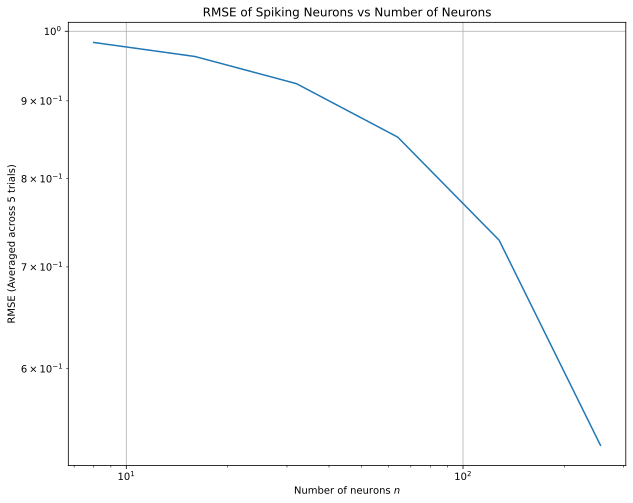

In [404]:
n_arr = [2**i for i in range(3, 9)]
num_of_runs = 5

RMSE_n = []

for curr_n in n_arr:
    RMSE_avg = []

    for i in range(num_of_runs):
        _, x_t, _, _ = generate_band_limited_white_noise(rms, limit, _seed=(i*curr_n))

        maximum_firing_rates = np.random.uniform(100, 200, size=(curr_n, 1))
        x_intercepts = np.random.uniform(-radius, radius, size=(curr_n, 1)) 
        encoders = np.random.choice([1, -1], size=(curr_n, 1))

        alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / Constants.TAU_RC) * (Constants.TAU_REF - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)
        j_bias = (radius - (x_intercepts / (1.0 - np.exp((1.0 / Constants.TAU_RC) * (Constants.TAU_REF - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)

        A_spiking_voltage, A_spiking_spike = simulate_LIF_neuron(x_t, encoders.reshape(-1), alphas.reshape(-1), j_bias.reshape(-1))
        noisy_D = np.array(np.linalg.lstsq(A_spiking_spike @ A_spiking_spike.T + len(x_t) * np.square(Constants.SIGMA) * np.eye(curr_n), A_spiking_spike @ x_t, rcond=None)[0])
        x_hat_t = A_spiking_spike.T @ noisy_D
        x_hat_t = np.convolve(x_hat_t, h_n0_t)

        x_hat_t_RMSE = rmse(x_t, x_hat_t[:len(x_t)])
        RMSE_avg.append(x_hat_t_RMSE)

    RMSE_avg = sum(RMSE_avg) / len(RMSE_avg)
    RMSE_n.append(RMSE_avg)

plt.figure(figsize=(10, 8))
plt.loglog(n_arr, RMSE_n)
plt.title('RMSE of Spiking Neurons vs Number of Neurons')
plt.xlabel('Number of neurons $n$')
plt.ylabel('RMSE (Averaged across 5 trials)')
plt.grid(True)
plt.show()

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

From the plot above, it appears that as the neuron count increases, the error (characterized by the RMSE metric) decreases. This makes intuitive sense because having a higher number of neurons with various parameters of alpha, e (encoder), and j_bias allows for a more accurate approximation of the original signal since it provides the neural population with more 'weights' to control to be able to better decode the original signal. Additionally, as n increases, the total energy of the activation matrix also increases, allowing for the decoded signal to more accurately match the magnitude of the original signal.

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

In [405]:
class NeuronGroupScalar:
    def __init__(self, _n: int, _radius: float, _f, _dx: float = 0.5, _tau_ref: float = tau_ref, _tau_RC: float = tau_RC):
        self.n = _n # number of neurons
        self.dx = _dx  # step size
        self.radius = _radius
        self.tau_ref = _tau_ref  
        self.tau_RC = _tau_RC

        self.x = np.arange(-radius, radius, dx)
        self.y = _f(x)
        self.maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
        self.x_intercepts = np.random.uniform(-radius, radius, size=(n, 1))
        self.encoders = np.random.choice([1, -1], size=(n, 1))

        self.alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)
        self.j_bias = (radius - (x_intercepts / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)

        self.A = G(alphas * encoders @ x.reshape(1, len(x)) + j_bias)
        self.D_f = np.array(np.linalg.lstsq(A @ A.T + len(x) * np.square(sigma) * np.eye(n), A @ y, rcond=None)[0])

    def simulate(self, T, dt, f):
        f_t = f(np.arange(0, T, dt))
        A_spiking_spike = simulate_LIF_neuron(f_t, dt, resting_voltage, threshold_voltage, normalized_spike_voltage, self.tau_RC, self.tau_ref, self.encoders.reshape(-1), self.alphas.reshape(-1), self.j_bias.reshape(-1))[1]

        

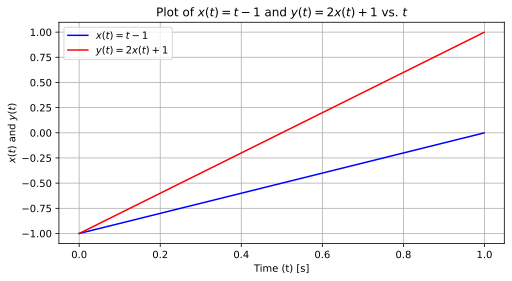

In [406]:
n = 200 # number of neurons
dx = 0.05  # step size
radius = 1.0
tau_ref = 2.0e-3    
tau_RC = 20.0e-3

# First Group
x = np.arange(-radius, radius, dx)
fx = 2*x + 1
maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
x_intercepts = np.random.uniform(-radius, radius, size=(n, 1))
encoders = np.random.choice([1, -1], size=(n, 1))

alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)
j_bias = (radius - (x_intercepts / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)

A = G(alphas * encoders @ x.reshape(1, len(x)) + j_bias)
D_fx = np.array(np.linalg.lstsq(A @ A.T + len(x) * np.square(sigma) * np.eye(n), A @ fx, rcond=None)[0])

# Second Group
y = np.arange(-radius, radius, dx)
fy = y
maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
x_intercepts = np.random.uniform(-radius, radius, size=(n, 1))
encoders = np.random.choice([1, -1], size=(n, 1))

alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)
j_bias = (radius - (x_intercepts / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (radius - x_intercepts)

A = G(alphas * encoders @ y.reshape(1, len(y)) + j_bias)
D_fy = np.array(np.linalg.lstsq(A @ A.T + len(x) * np.square(sigma) * np.eye(n), A @ y, rcond=None)[0])

# Computing a function
T = 1.0  # Total time [s]
dt = 1.0e-3
t = np.arange(0, T, dt)
x_t = t - 1.0
y_t = 2*x_t + 1

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(t, x_t, label=r'$x(t) = t - 1$', color='b')
plt.plot(t, y_t, label=r'$y(t) = 2x(t) + 1$', color='r')
plt.xlabel('Time (t) [s]')
plt.ylabel(r'$x(t)$ and $y(t)$')
plt.title(r'Plot of $x(t) = t - 1$ and $y(t) = 2x(t) + 1$ vs. $t$')
plt.grid(True)
plt.legend()
plt.show()

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

In [407]:
# ✍ <YOUR SOLUTION HERE>

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

In [408]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

✍ \<YOUR SOLUTION HERE\>

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [409]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [410]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [411]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [412]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

✍ \<YOUR SOLUTION HERE\>